In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flo-20k-data-set/flo_data_20k.csv


In [2]:
!pip install lifetimes
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 12.7 MB/s eta 0:00:00


In [3]:
df_ = pd.read_csv("/kaggle/input/flo-20k-data-set/flo_data_20k.csv")
df = df_.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

Four variables has type of float and others have that of objects.

In [4]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR]


In [5]:
# Let's define the outlier_thresholds and replace_with_thresholds functions required to suppress outliers.
# Note: When calculating CLTV, the frequency values need to be integers. Therefore, let's round the lower and upper limits using round().
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit,0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,0)

In [6]:
# Let's suppress the outliers in the variables 
# order_num_total_ever_online, order_num_total_ever_offline, customer_value_total_ever_offline, and customer_value_total_ever_online if they exist:

columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online"]

for col in columns:
    replace_with_thresholds(df, col)

In [7]:
# Let's create new variables for each customer's total number of purchases and total spending:
df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total,customer_value_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN],5.00,939.37
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.00,2013.55
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]",5.00,585.32
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]",2.00,121.97
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR],2.00,209.98


In [8]:
# Let's examine the variable types. We will convert the date-related variables to the 'date' type.
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

In [9]:
df["last_order_date"].max()

Timestamp('2021-05-30 00:00:00')

In [10]:
# Let's set the analysis date as two days after the date of the most recent purchase in the dataset.
df["last_order_date"].max() # 2021-05-30
analysis_date = df["last_order_date"].max() + dt.timedelta(days=2)

In [11]:
# Let's create a new CLTV dataframe containing the customer_id, recency_cltv_weekly, T_weekly, frequency, and monetary_cltv_avg values.

# recency: Time elapsed since the last purchase. Weekly. (per user) / First purchase - Last purchase
# T: Customer's age. Weekly. (how much time has passed since the first purchase relative to the analysis date)
# frequency: Total number of repeat purchases (frequency>1)
# monetary: Average revenue per purchase

cltv_df = pd.DataFrame()

cltv_df["customer_id"] = df["master_id"]
cltv_df["recency_cltv_weekly"] = (df["last_order_date"] - df["first_order_date"]).dt.days / 7
cltv_df["T_weekly"] = (analysis_date - df["first_order_date"]).dt.days / 7
cltv_df["frequency"] = df["order_num_total"]
cltv_df["monetary_cltv_avg"] = df["customer_value_total"] / df["order_num_total"]

cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

cltv_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          19945 non-null  object 
 1   recency_cltv_weekly  19945 non-null  float64
 2   T_weekly             19945 non-null  float64
 3   frequency            19945 non-null  float64
 4   monetary_cltv_avg    19945 non-null  float64
dtypes: float64(4), object(1)
memory usage: 779.2+ KB


In [12]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


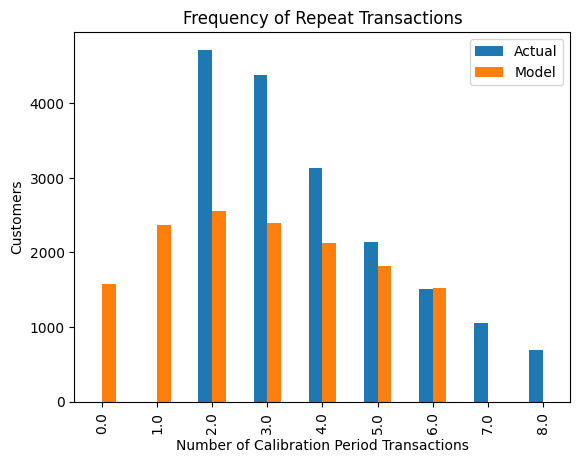

In [13]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])


# Predict the expected purchases from customers within the next 3 months and add them as exp_sales_3_month to the cltv dataframe.
cltv_df["exp_sales_3_month"] = bgf.predict(4*3,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])

# Predict the expected purchases from customers within the next 6 months and add them as exp_sales_6_month to the cltv dataframe.
cltv_df["exp_sales_6_month"] = bgf.predict(4*6,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])

# Examine the top 10 customers who are expected to make the most purchases in the 3rd and 6th months. Is there any difference?
cltv_df.sort_values("exp_sales_3_month",ascending=False)[:10]

cltv_df.sort_values("exp_sales_6_month",ascending=False)[:10]

plot_period_transactions(bgf)
plt.show()

In [14]:
# Let's fit the Gamma-Gamma model.
# Let's predict the average value customers will leave and add it to the cltv dataframe as 'exp_average_value'.
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])

cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                cltv_df['monetary_cltv_avg'])
cltv_df.head()

# Let's calculate the 6-month CLTV and add it to the dataframe as 'cltv'.
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6*4,
                                   freq="W",
                                   discount_rate=0.01)

cltv_df["cltv"] = cltv


# Let's observe the top 20 customers with the highest CLTV values.
cltv_df.sort_values("cltv",ascending=False)[:20]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.86,7.86,4.00,1401.80,1.09,2.19,1449.06,12198.01
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.14,13.14,11.00,758.09,1.97,3.94,767.36,11628.45
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.71,101.00,7.00,1106.47,0.72,1.44,1127.61,6264.29
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.29,74.57,16.00,501.87,1.57,3.13,506.17,6094.33
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.00,166.22,4.66,9.31,166.71,5970.71
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.43,34.43,8.00,601.23,1.27,2.53,611.49,5952.10
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.29,9.43,2.00,862.69,0.79,1.59,923.68,5640.69
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56,262.07,5605.40
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17,229.61,5446.29
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.86,15.57,3.00,743.59,0.87,1.74,778.05,5216.02


In [15]:
# Let's segment all customers into 4 groups based on their 6-month standardized CLTV and add the group names to the dataset.

cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])

cltv_df["cltv_segment"] = pd.cut(cltv_df["cltv"], bins=[0, 25, 75, 100, 150], labels=["D", "C", "B", "A"])

cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87,0.97,1.95,193.63,1450.56,NaN
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88,0.98,1.97,96.67,731.02,NaN
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06,0.67,1.34,120.97,623.96,NaN
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98,0.70,1.40,67.32,362.69,NaN
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99,0.40,0.79,114.33,348.27,NaN


In [16]:
# Let's turn the entire process into functions:
def create_cltv_df(dataframe):

    # Data Preparation
    columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline","customer_value_total_ever_online"]
    for col in columns:
        replace_with_thresholds(dataframe, col)

    dataframe["order_num_total"] = dataframe["order_num_total_ever_online"] + dataframe["order_num_total_ever_offline"]
    dataframe["customer_value_total"] = dataframe["customer_value_total_ever_offline"] + dataframe["customer_value_total_ever_online"]
    dataframe = dataframe[~(dataframe["customer_value_total"] == 0) | (dataframe["order_num_total"] == 0)]
    date_columns = dataframe.columns[dataframe.columns.str.contains("date")]
    dataframe[date_columns] = dataframe[date_columns].apply(pd.to_datetime)

    # Creation of the CLTV Data Structure
    dataframe["last_order_date"].max()  # 2021-05-30
    analysis_date = dt.datetime(2021, 6, 1)
    cltv_df = pd.DataFrame()
    cltv_df["customer_id"] = df["master_id"]
    cltv_df["recency_cltv_weekly"] = (df["last_order_date"] - df["first_order_date"]).dt.days / 7
    cltv_df["T_weekly"] = (analysis_date - df["first_order_date"]).dt.days / 7
    cltv_df["frequency"] = df["order_num_total"]
    cltv_df["monetary_cltv_avg"] = df["customer_value_total"] / df["order_num_total"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

    # Establishing the BG-NBD Model
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency_cltv_weekly'],
            cltv_df['T_weekly'])
    cltv_df["exp_sales_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency_cltv_weekly'],
                                               cltv_df['T_weekly'])
    cltv_df["exp_sales_6_month"] = bgf.predict(4 * 6,
                                               cltv_df['frequency'],
                                               cltv_df['recency_cltv_weekly'],
                                               cltv_df['T_weekly'])

    # Establishing the Gamma-Gamma Model
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
    cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                           cltv_df['monetary_cltv_avg'])

    # CLTV Prediction
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'],
                                       cltv_df['monetary_cltv_avg'],
                                       time=6*4,
                                       freq="W",
                                       discount_rate=0.01)
    cltv_df["cltv"] = cltv

    # CLTV Segmentation
    cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])
    return cltv_df

cltv_df = create_cltv_df(df)
cltv_df.head(10)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87,0.97,1.95,193.63,1450.56,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88,0.98,1.97,96.67,731.02,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06,0.67,1.34,120.97,623.96,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98,0.70,1.40,67.32,362.69,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99,0.40,0.79,114.33,348.27,D
5,e585280e-aae1-11e9-a2fc-000d3a38a36f,120.86,132.29,3.00,66.95,0.38,0.77,71.35,210.51,D
6,c445e4ee-6242-11ea-9d1a-000d3a38a36f,32.57,64.86,4.00,93.98,0.65,1.30,98.13,492.20,C
7,3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f,12.71,54.57,2.00,81.81,0.52,1.04,89.57,358.12,D
8,cfbda69e-5b4f-11ea-aca7-000d3a38a36f,58.43,70.71,5.00,210.94,0.71,1.42,217.30,1182.99,A
9,1143f032-440d-11ea-8b43-000d3a38a36f,61.71,96.00,2.00,82.98,0.39,0.79,90.81,275.73,D
